## Imports

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import random
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
# from matplotlib import animation
# from JSAnimation.IPython_display import display_animation
# import gym
import scipy.stats as stats
from scipy.stats import norm
from collections import namedtuple
import statistics
import time
import os
from collections import deque
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

import yfinance as yf
import datetime as dt

import pickle

import import_ipynb
import Generate_Data
import Environment

/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100

## Defining Model Classes
- Actor: A neural network model that represents the policy in the DDPG algorithm, mapping states to continuous actions.

- Critic: A neural network model that estimates the Q-values, evaluating the quality of state-action pairs in the DDPG framework.

- ReplayBuffer: A data structure that stores past experiences (state, action, reward, next_state, done) to facilitate experience replay during training.

- OUNoise: Implements the Ornstein-Uhlenbeck process to generate temporally correlated noise, promoting exploration in continuous action spaces.

- DDPGAgent: Encapsulates the entire DDPG agent, integrating the Actor and Critic networks, Replay Buffer, and OUNoise, and providing methods for action selection, experience memorization, and network updates.

In [2]:
# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action = self.max_action * torch.tanh(self.fc3(x))
        return action

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Q Network
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(torch.cat([state, action], dim=1)))
        x = torch.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value


In [3]:
class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def size(self):
        return len(self.buffer)


In [4]:
class OUNoise:
    def __init__(self, action_dim, mu=0.0, theta=0.15, sigma=0.2):
        self.action_dim = 1
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.reset()
    
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
    
    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state.squeeze()  # Return as scalar if action_dim == 1


In [5]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer()
        self.ou_noise = OUNoise(action_dim)
        self.max_action = max_action

        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0

    def get_action(self, state, step=0, episode=0):
        return self.decide_action(state, step, episode)

    def decide_action(self, state, step, episode, add_noise=True):
        """
        Selects an action based on the given state, optionally adding exploration noise.
        """
        # Convert state to tensor and get action from the actor
        state = torch.FloatTensor(state).to(device).unsqueeze(0)  # Ensure 2D input for batch processing
        action = self.actor(state).cpu().data.numpy().flatten().item()  # Convert to scalar

        # Add noise for exploration if desired
        if add_noise:
            noise = self.ou_noise.noise() * self.max_action * 0.2  # Adjust noise scale
            # Ensure noise is scalar
            if isinstance(noise, np.ndarray):
                noise = noise.item() if noise.size == 1 else noise[0]
            elif isinstance(noise, float) or isinstance(noise, int):
                noise = noise
            else:
                raise ValueError("Unexpected noise type")
            
            action += noise
            action = np.clip(action, -self.max_action, self.max_action)

        return action

    def memorize(self, state, action, reward, next_state, done):
        """
        Stores experience in the replay buffer.
        """
        self.replay_buffer.add(state, action, reward, next_state, done)

    def update_agent(self, batch_size=64, gamma=0.99, tau=0.005):
        """
        Performs a training step for the agent.
        """
        if self.replay_buffer.size() < batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)

        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device).unsqueeze(1)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).unsqueeze(1).to(device)

        # Critic update
        with torch.no_grad():
            next_action = self.actor_target(next_state)
            target_Q = self.critic_target(next_state, next_action)
            target_Q = reward + (1 - done) * gamma * target_Q

        current_Q = self.critic(state, action)

        critic_loss = nn.MSELoss()(current_Q, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Target networks update
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            

## Model Training

In [6]:
def train_agent(env, agent, num_episodes=1000, num_steps=30, gamma=0.99):
    """
    Trains the agent in the given environment.

    Parameters:
    - env: The trading environment (Environment).
    - agent: The DDPG agent.
    - num_episodes: The number of training episodes.
    - num_steps: The number of steps per episode.
    - gamma: Discount factor for future rewards.

    Returns:
    - pl_history: A list containing the P&L history for each episode.
    - reward_history: A list containing the cumulative reward history for each episode.
    """
    
    pl_history = []  # Profit and loss history for each episode
    reward_history = []  # Total reward history for each episode
    std_pl_history = []  # Standard deviation of P&L for each episode ; added this 

    last_30_pl = []
    
    for episode in range(num_episodes):
        state = env.reset()  # Reset the environment and get the initial state
        total_reward = 0  # Track total reward for the episode
        pl_episode = []  # Track portfolio value (P&L) for the episode

        for step in range(num_steps):
            # Agent takes an action based on the current state
            action = agent.get_action(state, step=step, episode=episode)
            
            # Environment returns the next state, reward, and whether the episode is done
            next_state, reward, done, pv = env.step(action)
            
            # Accumulate total reward, discounted by gamma (for future rewards)
            total_reward += reward * np.power(gamma, episode)
            
            # Store the portfolio value (P&L) for the step
            pl_episode.append(pv)
            
            # Memorize the experience with the done flag
            agent.memorize(state, action, reward, next_state, done)
            
            # Update the agent with experiences from the replay buffer
            agent.update_agent()

            # Move to the next state
            state = next_state
            
            # If the episode is done, break out of the loop
            if done:
                break
        
        # At the end of the episode, calculate the total P&L and reward
        pl_total = sum(pl_episode)
        pl_history.append(pl_total)
        reward_history.append(total_reward)

        last_30_pl.append(pl_total)
        if len(last_30_pl) > 30:
            last_30_pl.pop(0)

        if episode >= 30:
            std = np.std(last_30_pl)
            std_pl_history.append(std)
        else:
            std_pl_history.append(np.nan)

        # if episode % 30 == 0 and episode != 0:
        #     std_pl_history.append(np.std(pl_episode[-30:]))  # Compute std dev of P&L for the episode # added this
        
        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}, P&L: {pl_total}, Std Dev P&L: {std_pl_history[-1]}") # added std dev part
    
    return pl_history, reward_history, std_pl_history


Episode 0/1000, Total Reward: -74.30261676164433, P&L: -1.1758804321289062, Std Dev P&L: nan
Episode 100/1000, Total Reward: -27.306887716691378, P&L: -19.43950653076172, Std Dev P&L: 897.9151146993827
Episode 200/1000, Total Reward: -44.7986761541, P&L: 860.5640411376953, Std Dev P&L: 953.6453489677579
Episode 300/1000, Total Reward: -4.3359638813582375, P&L: 428.1698226928711, Std Dev P&L: 860.7572096252295
Episode 400/1000, Total Reward: -1.0048539018322578, P&L: -99.22571182250977, Std Dev P&L: 794.6346722506129
Episode 500/1000, Total Reward: -2.53795305196514, P&L: 143.133544921875, Std Dev P&L: 348.3295718375887
Episode 600/1000, Total Reward: -0.3867358697188586, P&L: -87.86239624023438, Std Dev P&L: 529.4436987126771
Episode 700/1000, Total Reward: -3.8911681704959205, P&L: -1307.2715759277344, Std Dev P&L: 735.45859438385
Episode 800/1000, Total Reward: -0.03542773119949118, P&L: -120.85514068603516, Std Dev P&L: 648.6260330039539
Episode 900/1000, Total Reward: -0.0132366312

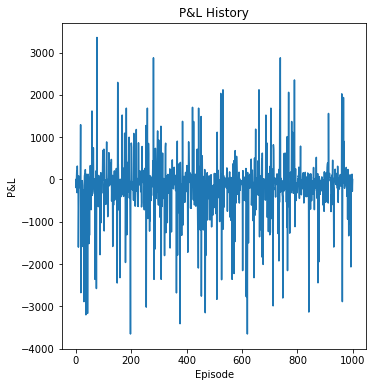

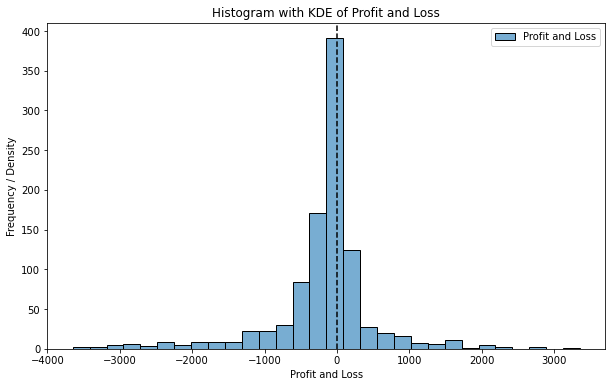

In [7]:
##Getting train datasets
features_train = Generate_Data.features_train
df_stock_train = Generate_Data.df_stock_train
call_options_train = Generate_Data.call_options_train

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up your environment with real AAPL stock and option data
env_train = Environment.Environment(
    stock_data=df_stock_train,
    option_data=call_options_train,
    features_data=features_train,
    T=30,
    n_steps=30,
    num_sold_opt=100,
    kappa=0.1,
    alpha=0.001
)
num_states = env_train.num_states
num_actions = env_train.num_actions
max_action = 10

ddpg_agent = DDPGAgent(num_states, num_actions, max_action)

# Train the agen
pl_history, reward_history, std_pl = train_agent(env_train, ddpg_agent, num_episodes=1000, num_steps=30)


plt.figure(figsize=(12, 6))

# Plot P&L history
plt.subplot(1, 2, 1)
plt.plot(pl_history)
plt.title("P&L History")
plt.xlabel("Episode")
plt.ylabel("P&L")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(pl_history, kde=False, bins=30, label="Profit and Loss", alpha=0.6)

plt.axvline(0, color='k', linestyle='--')  # Mark zero for reference
plt.xlabel("Profit and Loss")
plt.ylabel("Frequency / Density")
plt.title("Histogram with KDE of Profit and Loss")
plt.legend()
plt.show()

plt.show()

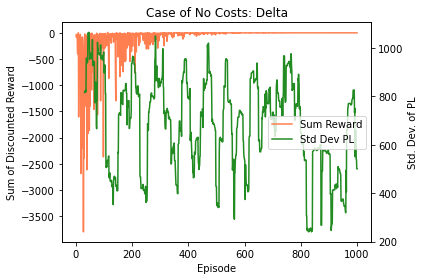

In [8]:

episodes = np.array(list(range(1, len(reward_history) + 1)))

# Create a figure for dual-axis plotting
fig = plt.figure(figsize=[6, 4])
ax1 = fig.add_subplot(111)

# Plot Sum of Discounted Reward
ax1.plot(episodes, reward_history, color='coral', label='Sum Reward')
ax1.set_xlabel('Episode')
ax1.set_ylabel("Sum of Discounted Reward")
h1, l1 = ax1.get_legend_handles_labels()

# Create a secondary axis for Std Dev PL
ax2 = ax1.twinx()
ax2.plot(episodes, std_pl, color='forestgreen', label='Std Dev PL')
ax2.set_ylabel("Std. Dev. of PL")
h2, l2 = ax2.get_legend_handles_labels()

# Combine legends for both axes and set the title
ax2.legend(h1 + h2, l1 + l2, loc='center right')
ax1.set_title('Case of No Costs: Delta')

plt.tight_layout()
plt.show()

In [9]:
import pickle

# Saving the entire agent
with open('models/ddpg_agent_full.pkl', 'wb') as f:
    pickle.dump(ddpg_agent, f)

## Notebook Summary
Train DDPG model, save as ddpg_agent_full